### Transfer Learning with Keras 3 (ImageDataGenerator + model.fit_generator)

## 1. Select Dataset Path and Preview Images

In [12]:
#Load all libraries ================================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

Found 90 images belonging to 6 classes.
dict_items([('Face', 0), ('Forearm', 1), ('Forehead', 2), ('LowerLeg', 3), ('Neck', 4), ('Palm', 5)])
90
[0 1 2 3 4 5]


C:\Program Files\Python36\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


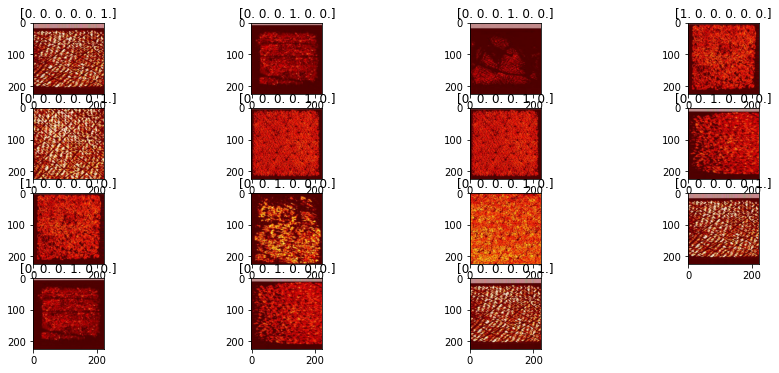

In [13]:
#Select image folders and create DataGenerators ====================================================
train_path = os.getcwd() + "\SkinArea"
test_path = os.getcwd() + "\SkinArea"


batch_size = 16
image_size = 224 # For Inception use 299 


train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

x_batch, y_batch = train_generator.next()

it = train_generator.class_indices
print(it.items())
print(train_generator.n)
print(np.unique(train_generator.classes))
num_classes = len(np.unique(train_generator.classes))

fig=plt.figure(figsize=(15,6))
columns = 4
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(y_batch[num])
    plt.imshow(image)
    
plt.show()

## 2. Creating the model and training

In [10]:
#Create and train a simple self defined model  ===============================================================================
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,Conv2D,MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3),  input_shape=(image_size, image_size, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))
print(model.summary())

# # Compile the model
model.compile(optimizer= 'adam' , loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])
#model.compile(optimizer= 'sgd' , loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n/batch_size,
        epochs=1)
        
model.save('fine_tune.h5')

# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 256)     7168      
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 256)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 256)     590080    
_________________________________________________________________
activation_6 (Activation)    (None, 109, 109, 256)     0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 1024)     

KeyboardInterrupt: 

## 3. Test the Model Performance and Prediction

Found 90 images belonging to 6 classes.


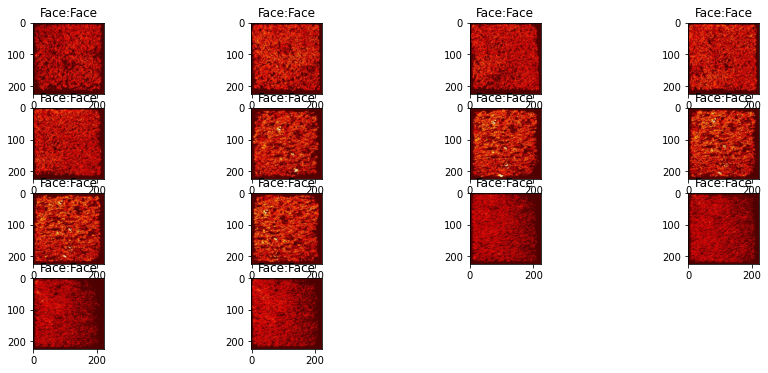

In [14]:
# Evaluate the performance ========================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#test image classified
#model = load_model('fine_tune.h5')

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
                        directory=test_path, 
                        target_size=(image_size, image_size),
                        color_mode='rgb',
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)
test_generator.reset()

fig=plt.figure(figsize=(15,6))
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()



## 4. Predcit_Generator and Save Results

In [8]:
# Predict and save the results =====================================================================
import pandas as pd 


STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

90/90 [==============================] - 28s 315ms/step


In [9]:
score = model.evaluate_generator(test_generator, STEP_SIZE_TEST, workers=12)
print("Loss: ", score[0], "Accuracy: ", score[1])


Loss:  0.0007045170641504228 Accuracy:  0.7111111283302307
